 # <span style = 'color:darkred'> Notebook structure </span style>


<a href=#imports> Imports & settings </a>
<a href=#read_in> Reading in all tweets </a>
<a href=#time_distr> Distribution over time </a>
<a href=#filter> Filter for relevant tweets </a>

    # <span style = 'color:darkred'> Imports & notebook settings </span style> <a name='imports' />


In [60]:
from IPython.core.display import display, HTML
import pyspark

from pyspark.sql import SQLContext, SparkSession

try:
    sc = pyspark.SparkContext(appName = 'App')
    spark = SparkSession(sparkContext=sc)
    print("SparkSession initialized")
except ValueError:
    print("SparkSession already initialized")

SparkSession initialized


In [56]:
# Python imports
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator
import glob
import numpy as np
import pandas as pd
# Spark imports
from pyspark.sql.functions import udf, year, month, dayofmonth, explode, lower, regexp_extract, split, upper
from pyspark.sql.types import *
import time
import datetime


In [57]:
colors = {"orange": np.array([255,128,14], dtype = np.float16),
          "blue": np.array([0,107,164], dtype = np.float16),
          "green": np.array([44, 160, 44], dtype = np.float16)
         }
for k in colors.keys():
    colors[k] = np.divide(colors[k], 255)

# <span style = 'color:darkred'> Reading in tweets </span style> <a name='read_in'/>

In [61]:
# Hadoop file path\n",
path = "/home/mma/Downloads/IPO_project/disctinct_tweets_test/ML_features22.parquet"
df = (spark.read.parquet(path)
         )
original_columns = df.columns
df = (df.withColumnRenamed("id_str", "tweet_id_str") #rename to avoid confusion with user_id, retweet_id, ...
            .withColumn("user_id_str", df.user.id_str)
        )
print( "The original columns were: {}".format(original_columns))

AttributeError: 'DataFrame' object has no attribute 'user'

# <span style = 'color:darkred'> Distribution over time </span style> <a name='time_distr'/>

In [31]:
# user defined function to strip date from created_at field, which originally is a string representation of datetime
udf_strip_pattern = udf(lambda string: (datetime.datetime.strptime(string, "%a %b %d %H:%M:%S +0000 %Y")).date(), DateType())
    # create dataframe containing only a data per tweet
tweetcount_per_date = df.select(udf_strip_pattern("created_at").alias("date")).groupBy("date").count()
    # cast dataframe to pandas for plotting
counts_pandas = tweetcount_per_date.toPandas()
    # insert missing dates with a count equal to 0 to have them appearing in the plot as well
first_date = min(counts_pandas["date"])
last_date = max(counts_pandas["date"])
print ("The data ranges from {} until {}".format(first_date, last_date)
dates_list = counts_pandas["date"].tolist()
missing_dates_and_counts = []n",
for i in dates_list:n",
    if i < last_date and i + datetime.timedelta(days = 1) not in dates_list:
            #print "Missing date: {}".format(i + datetime.timedelta(days = 1 ))
        dates_list.append(i + datetime.timedelta(days = 1))
        missing_dates_and_counts.append([i + datetime.timedelta(days = 1 ), 0])
print ("There are {} missing dates".format(len(missing_dates_and_counts)))
missing_pandas = pd.DataFrame(missing_dates_and_counts, columns = ["date", "count"])
    # concatenate available and missing data to one pandas dataframe for plotting
full_counts_per_date = pd.concat([counts_pandas, missing_pandas], axis = 0).reset_index(drop = True).sort_values("date", ascending = True)

SyntaxError: invalid syntax (<ipython-input-31-c251327be1dc>, line 11)

NameError: name 'first_date' is not defined

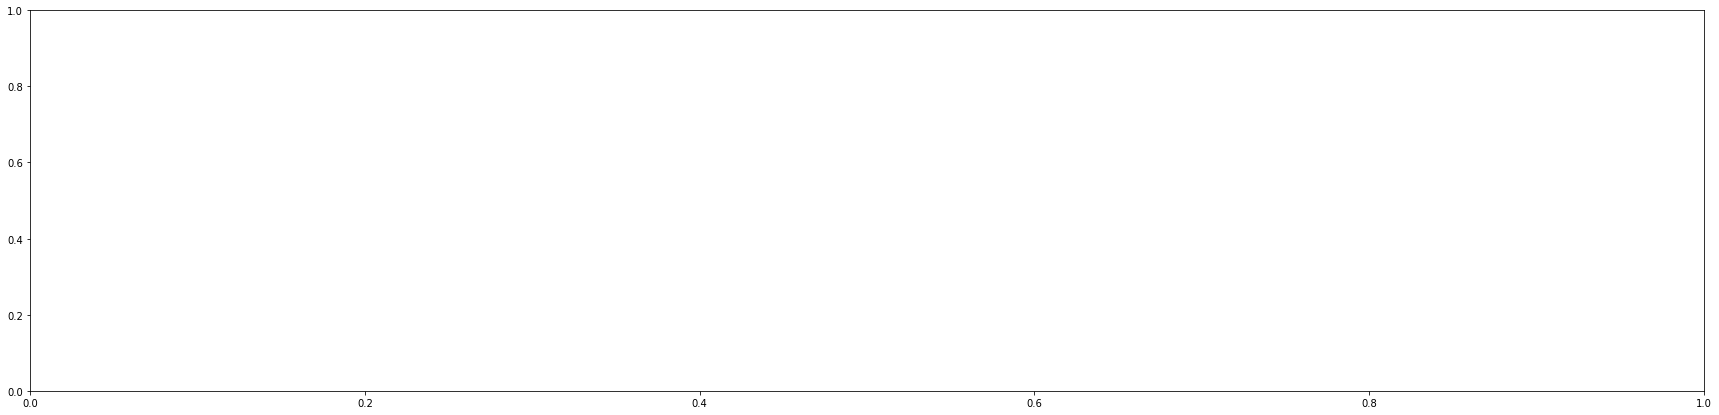

In [23]:
# plot tweet_count per date
fig = plt.figure(figsize = (30,7))
ax = fig.add_subplot(111)
ax.xaxis.set_minor_locator(MonthLocator())
plt.hlines(y = 1000000, xmin = first_date, xmax = last_date, linestyles = "dashed", 
color = colors["orange"])
plt.title("Tweets per day")
plt.plot(full_counts_per_date["date"], full_counts_per_date["count"], 
color = colors["blue"])

# <span style = 'color:darkred'> Filter for relevant tweets, i.e. related to IPOs </span style> <a name='filter'/>

In [32]:
with open("company_names.txt", "r") as f:
    companies_list = f.readlines()
    companies_list = map(lambda x: x.replace("n", "").lower(), companies_list)

In [35]:
def contains_company_name(text_column):
    company_mentions = 0
    for i in companies_list:
            # strip spaces out of tweets
        if i in text_column.replace(" ", ""):
            company_mentions += 1
    return company_mentions
udf_contains_company_name = udf(contains_company_name, 
                                IntegerType())

In [41]:
    # returns 0 if column is empty (no regexp match found), 1 otherwise (at least one regexp match found)
def non_empty_column(ipo_cashtag_column):
        if len(ipo_cashtag_column) > 0:
            return 1
        else:
            return 0
non_empty_column_udf = udf(non_empty_column)
    # REGEX to extract tickers or presence of IPO
ashtag_expression = '$[a-z]{1,6}'
ipo_expression = ' #ipo | ipo '
augmented_df = (df.select("tweet_id_str", "text", lower(df.text).alias("text_lower"))
                      .select("*", 
                               non_empty_column_udf(regexp_extract('text_lower', ipo_expression, 0)).alias("contains_ipo"),
                               non_empty_column_udf(regexp_extract('text_lower', cashtag_expression, 0)).alias("contains_cashtag"),
                               udf_contains_company_name("text_lower").alias("contains_company_name")
                              )
                   )
    filtered_df = augmented_df.filter((augmented_df.contains_ipo == 1) | 
                                      (augmented_df.contains_cashtag == 1) | 
                                      (augmented_df.contains_company_name == 1)
                                     )

NameError: name 'df' is not defined

In [42]:
filtered_augmented_df.drop("text_lower").take(50)

NameError: name 'filtered_augmented_df' is not defined

In [43]:
filtered_augmented_df.select("tweet_id_str").repartition(14*14).write.parquet("final_filter_batch.parquet", mode = "overwrite")

NameError: name 'filtered_augmented_df' is not defined

In [44]:
with open("company_names.txt", "r") as f:
        companies_list = f.readlines()
        companies_list = map(lambda x: x.replace("n", "").lower(), companies_list)

In [46]:
def contains_company_name(text_column):
    company_mentions = 0
    for i in companies_list:
            # strip spaces out of tweets
        if i in text_column.replace(" ", ""):
            company_mentions += 1
    return company_mentions
udf_contains_company_name = udf(contains_company_name, 
                                    IntegerType())

In [65]:
# returns 0 if column is empty (no regexp match found), 1 otherwise (at least one regexp match found)
def non_empty_column(ipo_cashtag_column):
    if len(ipo_cashtag_column) > 0:
        return 1
    else:
        return 0

non_empty_column_udf = udf(non_empty_column)

# REGEX to extract tickers or presence of IPO
cashtag_expression = '\$[a-z]{1,6}'
ipo_expression = ' #ipo | ipo '

augmented_df = (df.select("tweet_id_str", "text", lower(df.text).alias("text_lower"))
                  .select("*", 
                           non_empty_column_udf(regexp_extract('text_lower', ipo_expression, 0)).alias("contains_ipo"),
                           non_empty_column_udf(regexp_extract('text_lower', cashtag_expression, 0)).alias("contains_cashtag"),
                           udf_contains_company_name("text_lower").alias("contains_company_name")
                          )
               )

filtered_df = augmented_df.filter((augmented_df.contains_ipo == 1) | 
                                  (augmented_df.contains_cashtag == 1) | 
                                  (augmented_df.contains_company_name == 1)
                                 )

In [53]:
filtered_augmented_df.drop("text_lower").take(50)

NameError: name 'filtered_augmented_df' is not defined

In [54]:
filtered_augmented_df.select("tweet_id_str").repartition(14*14).write.parquet("final_filter_batch.parquet", mode = "overwrite")

NameError: name 'filtered_augmented_df' is not defined